# SABR model calibration

## SABR model definition

Under the SABR (stochastic $\alpha, \beta, \rho$) model the stock price is governed by the following system of SDE:
$$
\begin{aligned}
    &dF_t = \alpha_t F_t^{\beta} dW_t\\
    &d\alpha_t = v \alpha_t dZ_t\\
    dW_t dZ_t = \rho dt
\end{aligned}
$$with initial conditions $F, \alpha$.
The parameters satisfy conditions $0 \leq \beta \leq 1$, $\alpha \geq 0, v \geq 0$, $-1 \leq \rho \leq 1$

$\alpha_t$ is volatility, $v$ is vol of vol, $\beta$ is elasticity of variance and $\rho$ is correlation.

Let us introduce parameters:
$$
\begin{aligned}
&F_m = \sqrt{F K}\\
&\zeta = \dfrac{v}{\alpha}F_m^{1-\beta}\log \dfrac{F}{K}\\
&X(\zeta, \rho) = \log \dfrac{\sqrt{1 - 2 \zeta \rho + \zeta^2} + \zeta - \rho}{1-\rho}\\
&q_1 = \dfrac{(\beta-1)^2 \alpha^2 F_m^{2\beta - 2}}{24}\\
&q_2 = \dfrac{\rho \beta \alpha v F_m^{\beta - 1}}{4}\\
&q_3 = \dfrac{2-3\rho^2}{24}v^2\\
&S = 1 + T(q_1 + q_2 + q_3)\\
&D = F_m^{1-\beta}\left[ 1 + \dfrac{(\beta-1)^2}{24} \log^2 \dfrac{F}{K} + \dfrac{(\beta-1)^4}{1920}\log^4 \dfrac{F}{K}\right]\\
\end{aligned}
$$
$$
\sigma = \dfrac{\alpha S}{D} \times \dfrac{\zeta}{X(\zeta, \rho)}
$$

Our task is to find the derivatives of $\sigma$ with respect to parameters $\alpha, \beta, \rho, v$. 
$$
\log \sigma = \log \alpha + \log S - \log D + \log \zeta - \log X(\zeta, \rho)
$$

$$
\begin{aligned}
&\dfrac{\partial S}{\partial \alpha} = T\left(2 \dfrac{q_1}{\alpha} + \dfrac{q_2}{\alpha} \right) = \dfrac{T}{\alpha} \left(2q_1+q_2\right)\\
&\dfrac{\partial \zeta}{\partial \alpha} = -\dfrac{\zeta}{\alpha}\\
&\dfrac{\partial X}{\partial \alpha} = \dfrac{\partial X}{\partial \zeta} \dfrac{\partial \zeta}{\partial\alpha}\\
\end{aligned}
$$

$$
\begin{aligned}
&\dfrac{\partial S}{\partial \rho} = \dfrac{T \beta \alpha v F_m^{\beta - 1}}{4} - \dfrac{\rho v^2}{4}\\
&\dfrac{\partial X}{\partial \rho} = \dfrac{1}{1-\rho} - \dfrac{1}{\sqrt{\ldots}}\dfrac{\sqrt{\ldots} + \zeta}{\sqrt{\ldots} + \zeta - \rho}\\
\end{aligned}
$$

$$
\begin{aligned}
&\dfrac{\partial S}{\partial v} = T\left( \dfrac{q_2}{v} + 2 \dfrac{q_3}{v}\right) = \dfrac{T}{v}\left(q_2 + 2q_3\right)\\
&\dfrac{\partial \zeta}{\partial v} = \dfrac{\zeta}{v}\\
&\dfrac{\partial X}{\partial v} = \dfrac{\partial X}{\partial \zeta} \dfrac{\partial \zeta}{\partial v}\\
\end{aligned}
$$

$$
\begin{aligned}
&\dfrac{\partial \zeta}{\partial \beta} = - \log F_m \zeta\\
&\dfrac{\partial X}{\partial \beta} = \dfrac{\partial X}{\partial \zeta}\dfrac{\partial \zeta}{\partial \beta}\\
&\dfrac{\partial S}{\partial \beta} = T \left( \dfrac{2 q_1}{\beta - 1} + 2 \log F_m q_1 + \dfrac{q_2}{\beta} + \log F_m q_2 \right) = T \left( 2q_1 \left[ \dfrac{1}{\beta - 1} + \log F_m \right]
+ q_2 \left[ \dfrac{1}{\beta} + \log F_m \right]
\right)  \\
&\dfrac{\partial D}{\partial \beta} = -\log F_m D + F_m^{1-\beta} \left[ \dfrac{\beta - 1}{12} \log^2 \dfrac{F}{K} + \dfrac{(\beta - 1)^3}{480} \log^4 \dfrac{F}{K} \right]\\
&\\
&\\
\end{aligned}
$$

$$
\begin{aligned}
&\dfrac{\partial \log \sigma}{\partial \alpha} = \dfrac{1}{\alpha} + \dfrac{1}{S}\dfrac{\partial S}{\partial \alpha}
+ \dfrac{1}{\zeta} \dfrac{\partial \zeta }{\partial \alpha} - \dfrac{1}{X} \dfrac{\partial X}{\partial \alpha}\\
&\dfrac{\partial \log \sigma}{\partial \rho} = \dfrac{1}{S} \dfrac{\partial S}{\partial\rho} - \dfrac{1}{X} \dfrac{\partial X}{\partial \rho}\\
&\dfrac{\partial \log \sigma}{\partial v} = \dfrac{1}{S}\dfrac{\partial S}{\partial v} + \dfrac{1}{\zeta}\dfrac{\partial \zeta}{\partial v} - \dfrac{1}{X}\dfrac{\partial X}{\partial v}\\
&\dfrac{\partial \log \sigma}{\partial \beta} = \dfrac{1}{S} \dfrac{\partial S}{\partial \beta} - \dfrac{1}{D} \dfrac{\partial D}{\partial \beta} + \dfrac{1}{\zeta}\dfrac{\partial \zeta}{\partial \beta} - \dfrac{1}{X}\dfrac{\partial X}{\partial \beta}\\
\end{aligned}$$


# Get data

In [1]:
def download_data():
    '''
        download historial data from deribit exchange
    '''
    import nest_asyncio
    nest_asyncio.apply()
    from tardis_dev import datasets
    
    datasets.download(
        exchange="deribit",
        data_types=["options_chain"],
        from_date="2022-09-01",
        to_date="2022-09-02",
        symbols=["OPTIONS"]
    )
    
    !gzip -d datasets/*.gz

In [2]:
import os.path

fname = './datasets/deribit_options_chain_2022-09-01_OPTIONS.csv'
if not os.path.isfile(fname):
    download_data()

In [3]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)

In [33]:
from sabr import SABR
from sabr_calibration import SABRCalibrator
from black_scholes import black_scholes, implied_volatility

In [34]:
#load dataset to the memory
df = pd.read_csv(fname, nrows=200000)

In [35]:
#list of all available instrument
set(df.underlying_index)

{'BTC-28OCT22',
 'BTC-2SEP22',
 'BTC-30DEC22',
 'BTC-30JUN23',
 'BTC-30SEP22',
 'BTC-31MAR23',
 'BTC-9SEP22',
 'ETH-28OCT22',
 'ETH-2SEP22',
 'ETH-30DEC22',
 'ETH-30JUN23',
 'ETH-30SEP22',
 'ETH-31MAR23',
 'ETH-9SEP22',
 'SOL-28OCT22',
 'SOL-2SEP22',
 'SOL-30SEP22',
 'SOL-9SEP22',
 'SYN.BTC-16SEP22',
 'SYN.BTC-1SEP22',
 'SYN.BTC-25NOV22',
 'SYN.ETH-16SEP22',
 'SYN.ETH-1SEP22',
 'SYN.ETH-25NOV22',
 'SYN.SOL-1SEP22'}

In [36]:
df.head(10)

,exchange,symbol,timestamp,local_timestamp,type,strike_price,expiration,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_index,underlying_price,delta,gamma,vega,theta,rho
0,deribit,ETH-30DEC22-1300-P,1661990399996000,1661990400002270,put,1300,1672387200000000,8046.0,0.1375,0.1465,123.0,101.36,0.1490,121.0,102.64,0.1478,102.05,ETH-30DEC22,1523.1100,-0.28662,0.00038,2.97707,-1.26233,-2.18163
1,deribit,ETH-30DEC22-15000-P,1661990400007000,1661990400011122,put,15000,1672387200000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.8488,135.30,ETH-30DEC22,1523.1100,-0.99470,0.00001,0.13314,-0.07485,-49.43078
2,deribit,ETH-31MAR23-4500-P,1661990400048000,1661990400061948,put,4500,1680249600000000,16.0,1.2695,NaN,NaN,NaN,2.2620,1.0,200.16,1.9889,97.66,ETH-31MAR23,1525.6200,-0.86084,0.00020,2.57325,-0.59455,-25.17323
3,deribit,ETH-25NOV22-1600-P,1661990400063000,1661990400073423,put,1600,1669363200000000,273.0,0.2170,0.2205,138.0,99.45,0.2240,101.0,101.29,0.2235,101.04,SYN.ETH-25NOV22,1524.3589,-0.44230,0.00053,2.90962,-1.72252,-2.37288
4,deribit,ETH-25NOV22-1600-P,1661990400096000,1661990400106456,put,1600,1669363200000000,273.0,0.2170,0.2205,138.0,99.45,0.2240,252.0,101.29,0.2235,101.04,SYN.ETH-25NOV22,1524.3589,-0.44230,0.00053,2.90962,-1.72252,-2.37288
5,deribit,BTC-30DEC22-21000-P,1661990400145000,1661990400153970,put,21000,1672387200000000,286.8,0.1795,0.1825,10.5,67.51,0.1900,8.0,70.80,0.1861,69.09,BTC-30DEC22,20038.5100,-0.46804,0.00005,45.75363,-13.13423,-43.21403
6,deribit,BTC-30DEC22-20000-P,1661990400150000,1661990400159447,put,20000,1672387200000000,1363.6,0.1530,0.1560,27.0,69.04,0.1595,8.0,70.60,0.1572,69.56,BTC-30DEC22,20038.5100,-0.41897,0.00005,44.95096,-12.99261,-38.06227
7,deribit,ETH-30DEC22-1300-P,1661990400152000,1661990400160133,put,1300,1672387200000000,8046.0,0.1375,0.1470,1.0,101.61,0.1490,121.0,102.64,0.1478,102.05,ETH-30DEC22,1523.1100,-0.28662,0.00038,2.97707,-1.26233,-2.18163
8,deribit,BTC-28OCT22-23000-C,1661990400192000,1661990400195281,call,23000,1666944000000000,202.1,0.0525,0.0520,18.2,65.66,0.0530,7.9,66.35,0.0523,65.89,BTC-28OCT22,20010.6600,0.34363,0.00007,29.17678,-16.76600,9.15609
9,deribit,ETH-25NOV22-2400-P,1661990400207000,1661990400217444,put,2400,1669363200000000,0.0,NaN,NaN,NaN,NaN,0.8120,1.0,200.04,0.6286,98.93,SYN.ETH-25NOV22,1524.3589,-0.76107,0.00043,2.28573,-1.32493,-4.95222


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   exchange          200000 non-null  object 
 1   symbol            200000 non-null  object 
 2   timestamp         200000 non-null  int64  
 3   local_timestamp   200000 non-null  int64  
 4   type              200000 non-null  object 
 5   strike_price      200000 non-null  int64  
 6   expiration        200000 non-null  int64  
 7   open_interest     200000 non-null  float64
 8   last_price        161457 non-null  float64
 9   bid_price         122469 non-null  float64
 10  bid_amount        122469 non-null  float64
 11  bid_iv            107341 non-null  float64
 12  ask_price         154459 non-null  float64
 13  ask_amount        154459 non-null  float64
 14  ask_iv            154459 non-null  float64
 15  mark_price        200000 non-null  float64
 16  mark_iv           20

## Select options on BTC

In [38]:
def select_data(df: pd.DataFrame):
    btc_ind = [symbol.startswith('BTC') for symbol in df.underlying_index]

    columns_to_drop = ['exchange', 'symbol', 'local_timestamp', 'underlying_index', 
                       'delta', 'gamma', 'vega', 'theta', 'rho']
    
    btc = df[btc_ind].reset_index(drop=True).drop(columns_to_drop, axis=1)

    #tau is time before expiration in years
    btc['tau'] = (btc.expiration - btc.timestamp) / 1e6 / 3600 / 24 / 365
    #days before exp
    btc['days'] = (btc['tau'] * 365).astype(int)

    K = btc.strike_price.values
    F = btc.underlying_price.values

    payoff = np.maximum( F - K, 0.0 )
    payoff[btc.type == 'put'] = np.maximum( K - F, 0.0)[btc.type == 'put']

    btc["payoff"] = payoff

    btc['mid_price'] = 0.5 * (btc.ask_price + btc.bid_price)
    
    btc_grouped = btc.groupby(['type', 'expiration', 'strike_price'])\
    .agg(lambda x: x.iloc[-1]).reset_index().drop(["timestamp"], axis=1)
    
    put = btc_grouped[btc_grouped.type == 'put'].drop(['type'], axis=1).reset_index(drop=True)

    call = btc_grouped[btc_grouped.type == 'call'].drop(['type'], axis=1).reset_index(drop=True)
    
    return put, call

In [39]:
put, call = select_data(df)

In [40]:
put.head(10)

,expiration,strike_price,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_price,tau,days,payoff,mid_price
0,1662105600000000,13000,20.5,0.0010,NaN,NaN,NaN,0.0005,34.0,309.42,0.0000,127.05,20087.59,0.003641,1,0.00,NaN
1,1662105600000000,14000,38.4,0.0005,NaN,NaN,NaN,0.0005,42.5,261.68,0.0000,127.05,20087.59,0.003641,1,0.00,NaN
2,1662105600000000,15000,130.0,0.0005,NaN,NaN,NaN,0.0005,39.0,216.69,0.0000,120.27,20087.59,0.003641,1,0.00,NaN
3,1662105600000000,16000,578.2,0.0005,NaN,NaN,NaN,0.0010,89.0,193.13,0.0000,101.18,20087.59,0.003641,1,0.00,NaN
4,1662105600000000,17000,579.9,0.0005,NaN,NaN,NaN,0.0005,11.0,132.83,0.0000,95.26,20087.59,0.003641,1,0.00,NaN
5,1662105600000000,18000,3570.2,0.0005,NaN,NaN,NaN,0.0005,12.0,92.77,0.0004,88.26,20087.92,0.003641,1,0.00,NaN
6,1662105600000000,19000,2387.5,0.0020,0.0020,15.4,71.98,0.0025,20.5,76.60,0.0022,74.19,20087.66,0.003641,1,0.00,0.00225
7,1662105600000000,19500,932.7,0.0065,0.0050,7.3,64.98,0.0055,13.4,67.76,0.0052,66.41,20088.07,0.003641,1,0.00,0.00525
8,1662105600000000,20000,1362.8,0.0135,0.0115,39.9,56.46,0.0130,27.1,62.76,0.0124,60.35,20087.18,0.003640,1,0.00,0.01225
9,1662105600000000,20500,672.5,0.0200,0.0255,14.2,52.09,0.0275,28.6,61.90,0.0266,57.68,20087.35,0.003641,1,412.65,0.02650


In [41]:
call.head(10)

,expiration,strike_price,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_price,tau,days,payoff,mid_price
0,1662105600000000,13000,0.0,NaN,0.2425,3.0,NaN,0.4480,3.0,500.00,0.3528,127.05,20087.35,0.003641,1,7087.35,0.34525
1,1662105600000000,14000,0.0,NaN,0.1925,3.0,NaN,0.3980,3.0,500.00,0.3031,127.05,20087.92,0.003641,1,6087.92,0.29525
2,1662105600000000,15000,0.0,NaN,0.1430,3.0,NaN,0.3485,3.0,500.00,0.2533,120.27,20087.35,0.003641,1,5087.35,0.24575
3,1662105600000000,16000,0.0,NaN,0.0930,3.0,NaN,0.2985,3.0,500.00,0.2035,101.18,20087.92,0.003641,1,4087.92,0.19575
4,1662105600000000,17000,0.0,NaN,0.0435,3.0,NaN,0.2490,3.0,500.00,0.1537,95.26,20087.35,0.003641,1,3087.35,0.14625
5,1662105600000000,18000,0.0,NaN,NaN,NaN,NaN,0.1995,3.0,500.00,0.1043,88.26,20087.35,0.003641,1,2087.35,NaN
6,1662105600000000,19000,8.9,0.0420,0.0055,2.0,NaN,0.1515,3.3,500.00,0.0564,74.19,20087.92,0.003641,1,1087.92,0.07850
7,1662105600000000,19500,52.4,0.0350,0.0330,7.4,57.59,0.0365,8.2,76.96,0.0345,66.41,20087.92,0.003641,1,587.92,0.03475
8,1662105600000000,20000,604.0,0.0140,0.0160,16.0,57.09,0.0170,3.8,61.29,0.0168,60.35,20087.59,0.003641,1,87.59,0.01650
9,1662105600000000,20500,633.3,0.0065,0.0055,6.5,54.83,0.0060,0.1,57.29,0.0061,57.68,20087.18,0.003640,1,0.00,0.00575


## Volatility smile

In [42]:
days = set(call.days.values)
days

{1, 8, 29, 57, 120, 211, 302}

In [43]:
day = 120

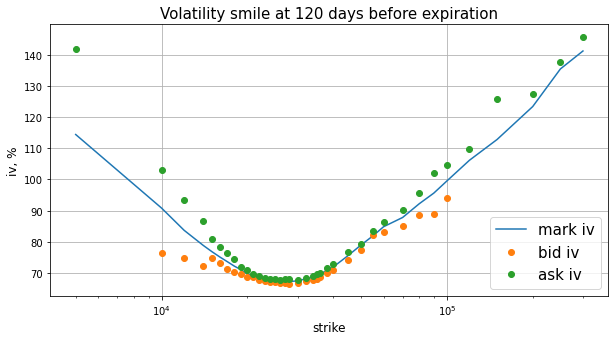

In [44]:
day = 120
call_ = call[call.days == day]

plt.figure(figsize=(10, 5))
plt.title(f"Volatility smile at {day} days before expiration", fontsize=15)
plt.semilogx(call_.strike_price, call_.mark_iv, label='mark iv')
plt.semilogx(call_.strike_price, call_.bid_iv, 'o', label='bid iv')
plt.semilogx(call_.strike_price, call_.ask_iv, 'o', label='ask iv')
plt.ylabel("iv, %", fontsize=12)
plt.xlabel("strike", fontsize=12)
plt.legend(fontsize=15)
plt.grid()

# Calibration

In [45]:
call.columns

Index(['expiration', 'strike_price', 'open_interest', 'last_price',
       'bid_price', 'bid_amount', 'bid_iv', 'ask_price', 'ask_amount',
       'ask_iv', 'mark_price', 'mark_iv', 'underlying_price', 'tau', 'days',
       'payoff', 'mid_price'],
      dtype='object')

In [46]:
def get_data_from_df(df : pd.DataFrame):
    """
        This function extracts out the money data from given dataframe
        
        Args:
            df(pd.DataFrame): dataframe of market data
            
        Returns:
            c(np.ndarray): option prices 
            iv(np.ndarray): implied vols
            K(np.ndarray): strikes
            F(np.ndarray): underlying prices
            T(np.ndarray): expiration times
            weights(np.ndarray): weights
    """
    
    #choose only out of the money options
    ind = (df.payoff == 0.0) & (~np.isnan(df.mid_price).values)
    df_ = df[ind].copy().reset_index(drop=True)
    
    #future price
    F = df_.underlying_price.values
    #strike
    K = df_.strike_price.values
    #time to exp
    T = df_.tau.values
    
    iv = 0.5 * ( df_.ask_iv.values + df_.bid_iv.values ) / 100.0
    c = df_.mid_price.values * F
    #weigths are propotional to open interest
    interest = df_.open_interest.values
    #weights
    weights = interest
    weights = weights / np.sum(weights)
    
    return c, iv, K, F, T, weights

def get_data_from_dfs(put:pd.DataFrame, call:pd.DataFrame):
    """
        This function extracts data from two dataframes for calls and puts and concatenates it
        
        Args:
            put(pd.DataFrame): dataframe with market data
            call(pd.DataFrame): dataframe with market data      
        
        Returns:
            c(np.ndarray): option prices 
            iv(np.ndarray): implied vols
            K(np.ndarray): strikes
            F(np.ndarray): underlying prices
            T(np.ndarray): expiration times
            weights(np.ndarray): weights
            typ(np.ndarray): list of types of an option, if True -- call option, else Put option
    """
    data_call = np.stack(get_data_from_df(call))
    data_put = np.stack(get_data_from_df(put))
    
    data = np.concatenate( (data_call, data_put), axis=-1)
    
    c, iv, K, F, T, weights = data
    
    typ = np.asarray([True] * data_call.shape[1] + [False] * data_put.shape[1])
    
    return c, iv, K, F, T, weights, typ

## Calibrating model on options with 120 days to expiration

In [47]:
day = 120

In [48]:
#extract data corresponding to day_before_exp = 120
X, iv, K, F, T, weights, typ = get_data_from_dfs(put[put.days == day], call[call.days == day])

weights = np.ones_like(X)

weights = weights / np.sum(weights)

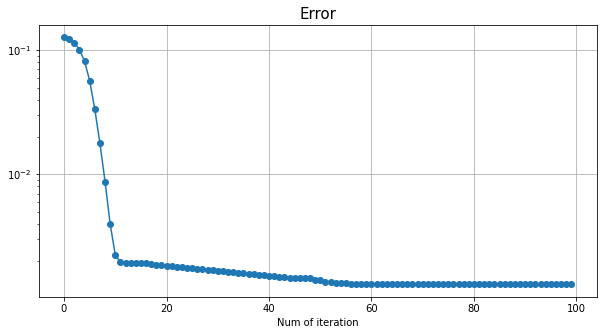

In [49]:
#create sabr calibrator object
sabr_calib = SABRCalibrator(interest_rate=0.0)
#call fit function
fs = sabr_calib.fit_iv(iv, K, F, T, Niter=100, weights=weights)
#save fitted model
sabr = sabr_calib.get_model()
#plot error
plt.figure(figsize=(10, 5))
plt.title("Error", fontsize=15)
plt.semilogy(fs, '-o')
plt.xlabel("Num of iteration")
plt.grid()

In [50]:
names = ["alpha ", "v ", "beta  ", "rho   "]

In [51]:
print("optimized parameters:", *zip(names, (sabr.sabr_params).round(5)), sep='\n' )

optimized parameters:
('alpha ', 0.68291)
('v ', 1.21781)
('beta  ', 1.0)
('rho   ', -0.2936)


## Calculating option prices for calibrated parameters

In [52]:
call_ = call[call.days == day]
put_  = put[put.days == day]

#make prediction on the whole data
#remember, we were fitting only on out of the money options
C_calib, ivc_calib = sabr( call_.strike_price.values, call_.underlying_price.values, call_.tau.values, True )
P_calib, ivp_calib = sabr( put_.strike_price.values, put_.underlying_price.values, put_.tau.values, False )

In [53]:
#extract mark and market implied volatility
iv_mark = call_.mark_iv.values
iv_market = 0.5 * ( call_.ask_iv.values + call_.bid_iv.values )

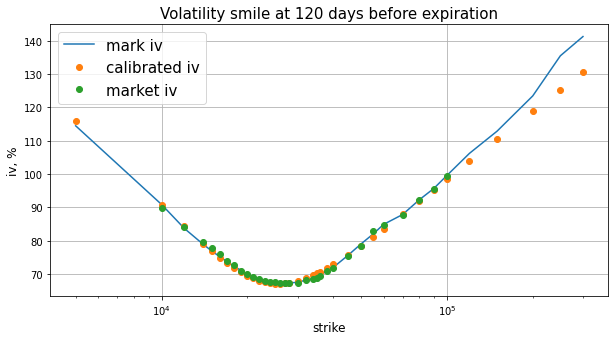

In [54]:
plt.figure(figsize=(10, 5))
plt.title(f"Volatility smile at {day} days before expiration", fontsize=15)
plt.semilogx(call_.strike_price.values, iv_mark, label='mark iv')
plt.semilogx(call_.strike_price.values, 100 * ivc_calib, 'o', label='calibrated iv')
plt.semilogx(call_.strike_price.values, iv_market, 'o', label='market iv')
plt.ylabel("iv, %", fontsize=12)
plt.xlabel("strike", fontsize=12)
plt.legend(fontsize=15)
plt.grid()

In [55]:
error = np.linalg.norm( 100 * ivc_calib - iv_mark ) / np.linalg.norm( iv_mark ) * 100

print(f"error in iv = {error:.4f}%")

error in iv = 3.1155%


In [56]:
C_mark = call_.mark_price * call_.underlying_price
P_mark = put_.mark_price * put_.underlying_price
error_call = 100 * np.linalg.norm(C_mark - C_calib) / np.linalg.norm(C_mark)
error_put = 100 * np.linalg.norm(P_mark - P_calib) / np.linalg.norm(P_mark)

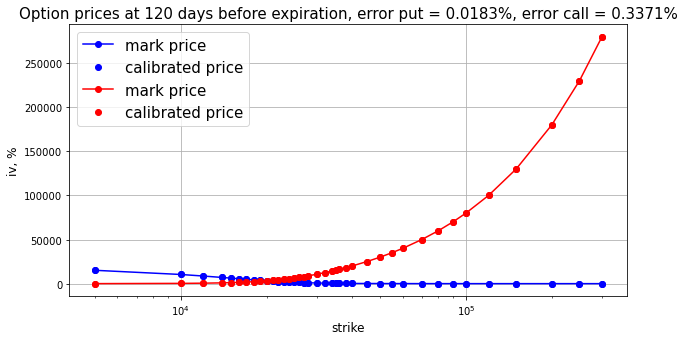

In [57]:
plt.figure(figsize=(10, 5))
plt.title(f"Option prices at {day} days before expiration, error put = {error_put:.4f}%, error call = {error_call:.4f}%", fontsize=15)
plt.semilogx(call_.strike_price.values, C_mark, '-ob',label='mark price')
plt.semilogx(call_.strike_price.values, C_calib, 'ob', label='calibrated price')

plt.semilogx(put_.strike_price.values, P_mark, '-or',label='mark price')
plt.semilogx(put_.strike_price.values, P_calib, 'or', label='calibrated price')


plt.ylabel("iv, %", fontsize=12)
plt.xlabel("strike", fontsize=12)
plt.legend(fontsize=15)
plt.grid()


## Calibrating SABR model on the whole dataset:

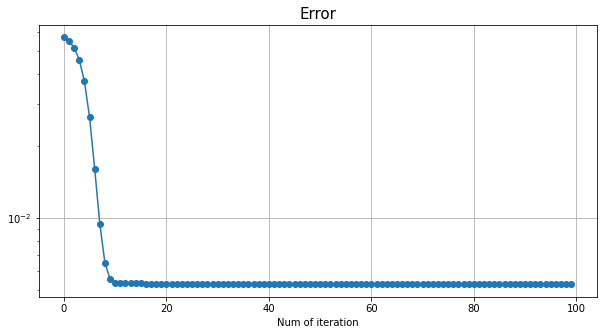

In [58]:
X, iv, K, F, T, weights, typ = get_data_from_dfs(put, call)

weights = np.ones_like(X)

weights = weights / np.sum(weights)

#create sabr calibrator object
sabr_calib = SABRCalibrator(interest_rate=0.0)
#call fit function
fs = sabr_calib.fit_iv(iv, K, F, T, Niter=100, weights=weights)
#save fitted model
sabr = sabr_calib.get_model()

#plot error
plt.figure(figsize=(10, 5))
plt.title("Error", fontsize=15)
plt.semilogy(fs, '-o')
plt.xlabel("Num of iteration")
plt.grid()

In [59]:
print("optimized parameters:", *zip(names, (sabr.sabr_params).round(5)), sep='\n' )

optimized parameters:
('alpha ', 0.71555)
('v ', 1.01795)
('beta  ', 1.0)
('rho   ', -0.30584)


## Plot results

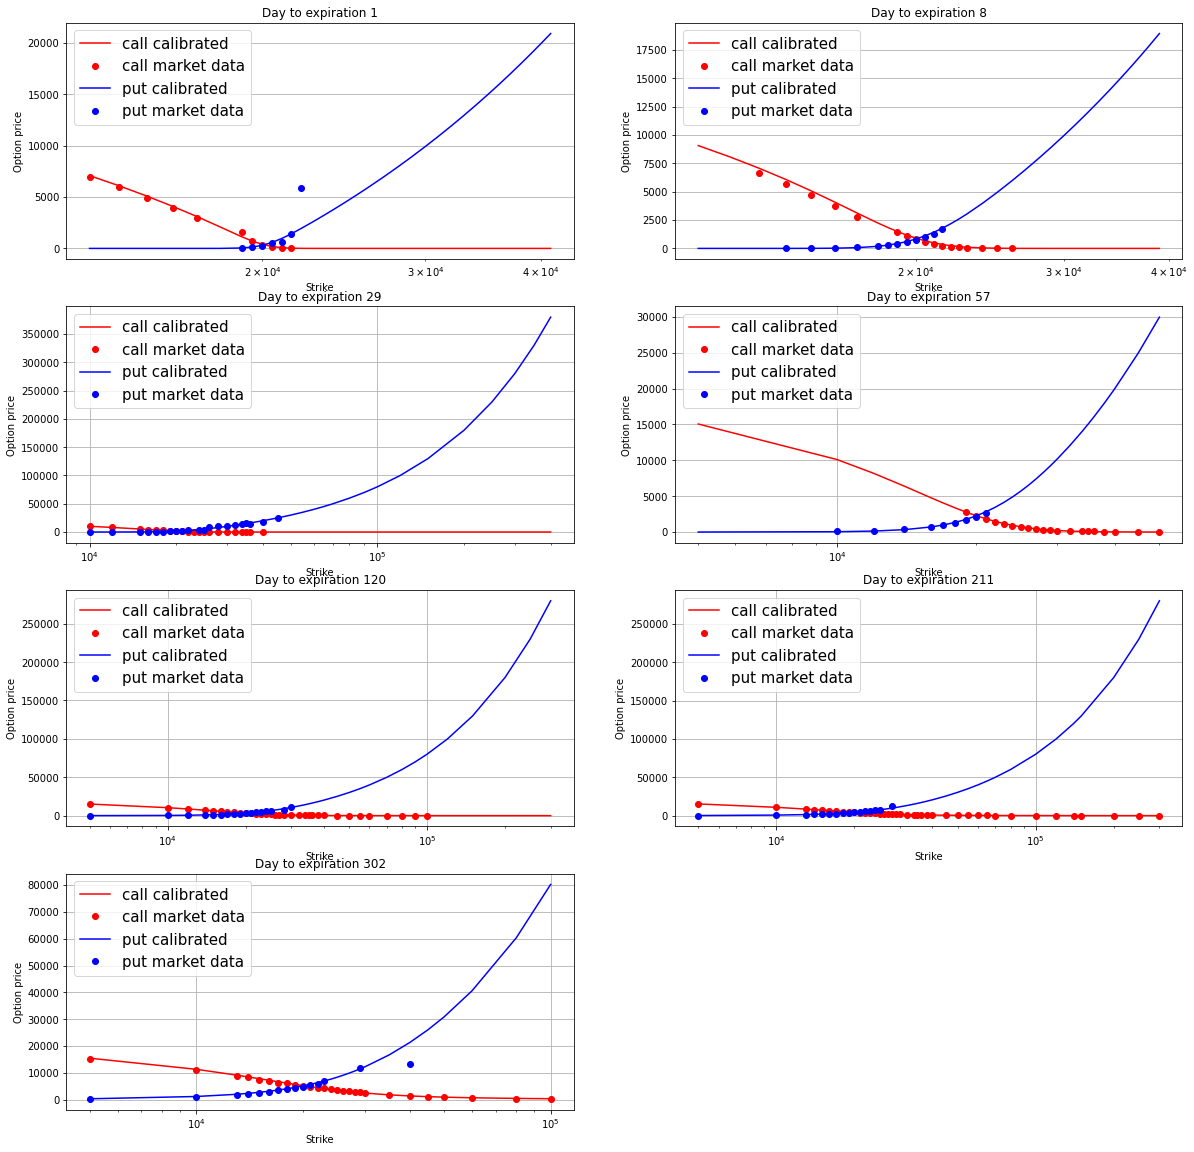

In [60]:
i = 1
plt.figure(figsize=(20, 20))
for (d, call_), (_, put_) in zip(call.groupby('days'), put.groupby('days')):
    
    K = call_.strike_price.values
    F = call_.underlying_price.values
    T = call_.tau.values
    
    #calibrated price and iv
    C_calib, iv_calib = sabr(K, F, T, True)
    #mid price
    C_mid = call_.mid_price.values * F
    #mark_price
    C_mark = call_.mark_price.values * F 
    
    ax = ax = plt.subplot(4, 2, i)
    ax.semilogx(K, C_calib, '-r', label='call calibrated')
    ax.semilogx(K, C_mid,   'ro', label='call market data')
    
    K = put_.strike_price.values
    F = put_.underlying_price.values
    T = put_.tau.values
    
    #calibrated price and iv
    P_calib, iv_calib = sabr(K, F, T, False)
    #mid price
    P_mid = put_.mid_price.values * F
    #mark_price
    P_mark = put_.mark_price.values * F 

    ax.semilogx(K, P_calib, '-b', label='put calibrated')
    ax.semilogx(K, P_mid,   'bo', label='put market data')
    
    ax.legend(fontsize=15)
    ax.set_title(f'Day to expiration {d}')
    ax.grid()
    
    ax.set_xlabel("Strike")
    ax.set_ylabel("Option price")
    
    i += 1

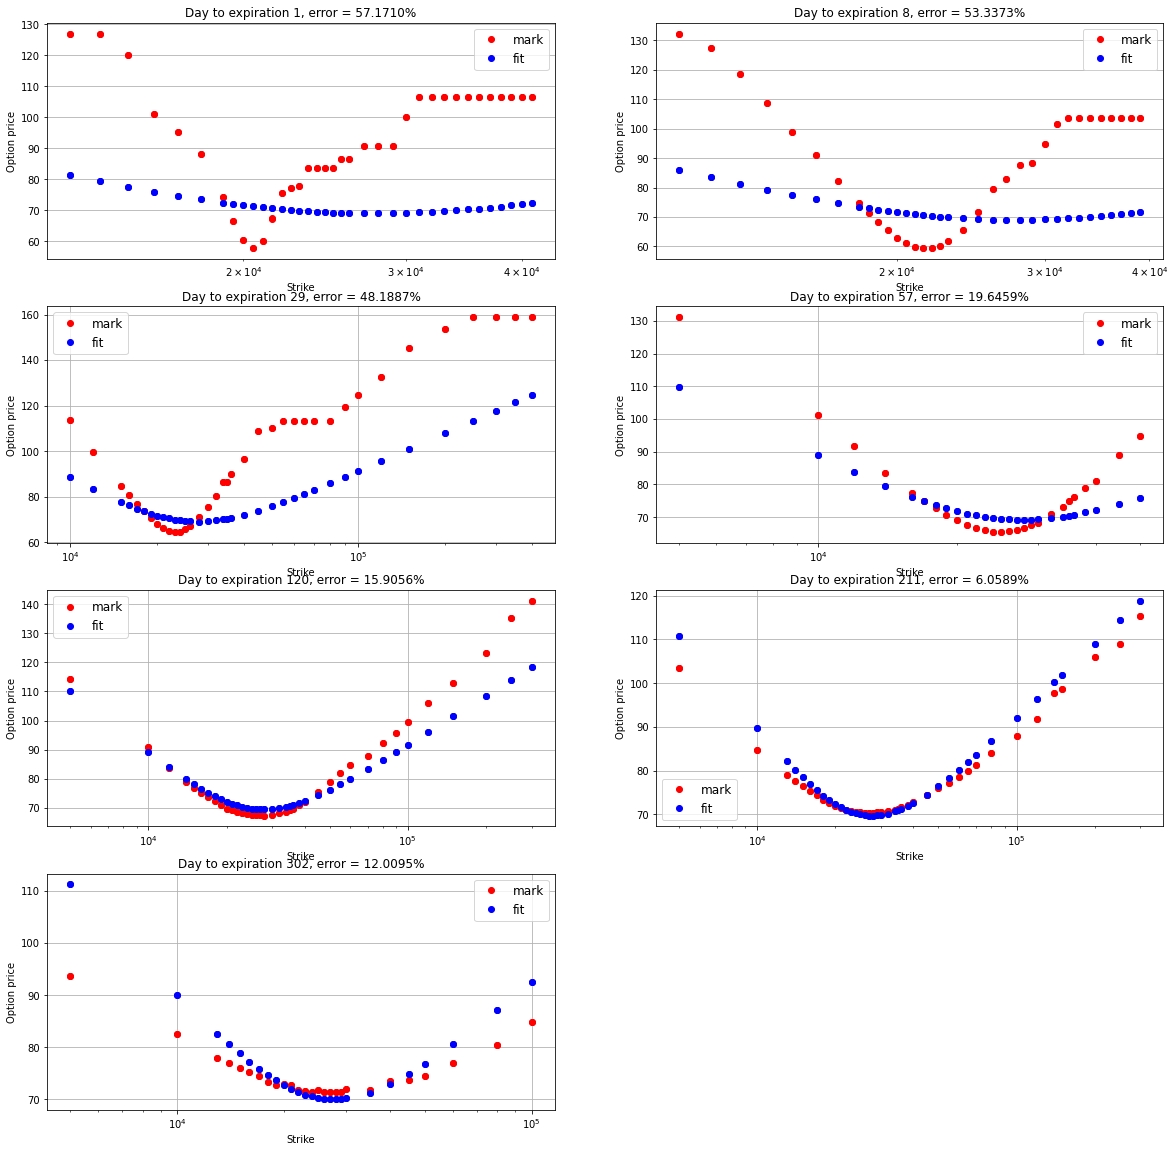

In [61]:
i = 1
plt.figure(figsize=(20, 20))
for (d, call_), (_, put_) in zip(call.groupby('days'), put.groupby('days')):
    
    K = call_.strike_price.values
    F = call_.underlying_price.values
    T = call_.tau.values
    
    #calibrated price and iv
    C_calib, ivc_calib = sabr(K, F, T, True)
    
    iv_mark = call_.mark_iv.values
    ax = plt.subplot(4, 2, i)
    ax.semilogx(K, iv_mark, 'or', label='mark')
    ax.semilogx(K, ivc_calib * 100, 'ob', label='fit')
    
    err_call = np.linalg.norm( 100 * ivc_calib - iv_mark ) / np.linalg.norm( iv_mark ) * 100

    
    K = put_.strike_price.values
    F = put_.underlying_price.values
    T = put_.tau.values
    
    #calibrated price and iv
    P_calib, ivp_calib = sabr(K, F, T, False)
    iv_mark = put_.mark_iv.values
    ax.semilogx(K, iv_mark, 'or')
    ax.semilogx(K, ivp_calib * 100, 'ob')
    
    err_put = np.linalg.norm( 100 * ivp_calib - iv_mark ) / np.linalg.norm( iv_mark ) * 100
    
    ax.set_title(f'Day to expiration {d}, error = {err_call + err_put:.4f}%')
    ax.grid()
    
    ax.set_xlabel("Strike")
    ax.set_ylabel("Option price")
    ax.legend(fontsize=12)
    i += 1